# **10 - All regions, KI**

**Objectives:**

* Restructure the workflow so that `[Level_01]` regions and `[GT]` are configurable.
* Make the stumps prioritization optional
* Tune the GBM model with extra parameters for maximum prediction accuracy with 10-fold cross validation
* Annotate workflow extensively

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import itertools

from numpy import ma  # masked array
from pandas.plotting import parallel_coordinates, andrews_curves, radviz

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from scipy.stats.distributions import uniform as sp_uni, randint as sp_int

import seaborn as sns

from boruta import BorutaPy

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, ShuffleSplit
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

from umap import UMAP

import lime 
from lime.lime_tabular import LimeTabularExplainer

import sklearn.datasets
from lime.lime_tabular import LimeTabularExplainer

sns.set(style="whitegrid")

* Early stopping monitor to prevent having to automatically stop GBM model training.

In [2]:
class EarlyStopMonitor:

    def __init__(self, window_length=25):
        self.window_length = window_length

    def window_boundaries(self, current_round):        
        lo = max(0, current_round - self.window_length + 1)
        hi = current_round + 1

        return lo, hi

    def __call__(self, current_round, regressor, _):        
        if current_round >= self.window_length - 1:
            lo, hi = self.window_boundaries(current_round)
            
            do_stop = np.mean(regressor.oob_improvement_[lo: hi]) < 0
            
            if do_stop:
                print('stopped after rounds: {}'.format(current_round))
            
            return do_stop
        else:
            return False

---

# Load the data

In [3]:
results_wd = '10_results/'

In [4]:
wd = '/media/tmo/data/work/datasets/02_ST'

logcpm_path = wd + '/ashley_21.03.2018/logcpm_merge_20180212.pickle'
meta_path = wd + '/meta/meta.parquet'

In [5]:
%%time
meta_df = pd.read_parquet(meta_path)

CPU times: user 135 ms, sys: 219 ms, total: 354 ms
Wall time: 186 ms


In [6]:
%%time
logcpm_df = pickle.load(open(logcpm_path, "rb"))

logcpm_df.index.name = 'spot_UID'
logcpm_df.reset_index(inplace=True)
logcpm_df.rename(columns={'sampleID': 'slide_ID'}, inplace=True)

CPU times: user 16.5 s, sys: 6.77 s, total: 23.3 s
Wall time: 23.3 s


In [7]:
st_df = logcpm_df.merge(meta_df, how='inner', on=['spot_UID', 'slide_ID'])

In [8]:
st_df['slide_ID'] = st_df['slide_ID'].astype('category', copy=False)
st_df['GT']       = st_df['GT'].astype('category', copy=False)
st_df['age']      = st_df['age'].astype('category', copy=False)
st_df['age_GT']   = st_df['age_GT'].astype('category', copy=False)

In [9]:
n_genes = 46454
gene_columns = st_df.columns[1:n_genes+1]

* merge with satellite tables

In [10]:
region_levels_df = pd.read_csv('region_levels.csv', sep=',', keep_default_na=False)

In [11]:
final_meta_df = pd.read_csv('final_metadata_scores.tsv', sep='\t', index_col=0)
final_meta_df.index.name = 'spot_UID'
final_meta_df.reset_index(inplace=True)
final_meta_df = final_meta_df[final_meta_df['AB'].notna()][['spot_UID', 'AB']]

### Log transform AB index
* the AB index is very skewed, this is not ideal for ML algorithm to regress upon
* use a masked array to compute natural log of AB index

cfr. **Jaak Simm**:
> if it is not transformed, the skewness will result in the fact that larger (absolute) deviations will be focused by the model
so lot of focus will be put into these high end values

In [12]:
final_meta_df['log_AB'] = ma.log(final_meta_df['AB'].as_matrix())

* let's check the distributions after log transform
* much nicer (Gaussian-like)
* there is some bimodality going on (could be batch effect, to investigate)

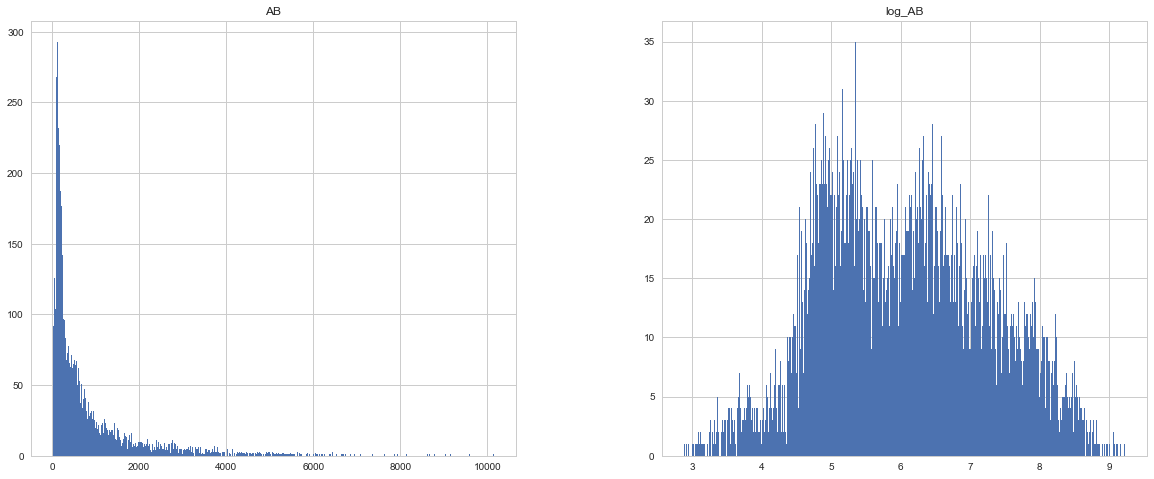

In [13]:
final_meta_df[final_meta_df['log_AB'] > 0][['AB', 'log_AB']].hist(bins=500, figsize=(20, 8))
plt.show()

In [14]:
full_df = st_df \
    .merge(region_levels_df, on='Region_predict') \
    .merge(final_meta_df, on='spot_UID')

In [15]:
expression_df = full_df[gene_columns]

In [16]:
expression_df.head()

,-343C11.2,00R_AC107638.2,0610005C13Rik,0610006L08Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,...,n-R5s90,n-R5s92,n-R5s93,n-R5s94,n-R5s95,n-R5s96,n-R5s97,n-R5s98,n-TSaga9,n-TStga1
0,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,4.984943,2.982974,2.982974,2.982974,...,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974
1,2.982974,2.982974,2.982974,2.982974,6.827059,5.924174,2.982974,2.982974,2.982974,2.982974,...,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974
2,2.982974,2.982974,2.982974,2.982974,2.982974,5.609164,2.982974,2.982974,5.609164,2.982974,...,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974
3,2.982974,2.982974,2.982974,2.982974,7.661385,2.982974,2.982974,2.982974,5.157746,5.157746,...,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974
4,2.982974,2.982974,2.982974,2.982974,6.738947,6.738947,2.982974,2.982974,2.982974,7.432553,...,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974


In [17]:
log_AB_df = full_df[['log_AB']]

In [18]:
# assert expression_df.shape == (10327, 46454) 
assert expression_df.shape == (10324, 46454)  # 3 less = damaged spots

### Figure out the bimodality

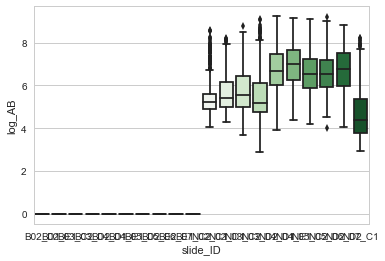

In [19]:
sns.boxplot(x="slide_ID", 
            y="log_AB", 
            data=full_df[['slide_ID', 'log_AB', 'GT']], 
            palette="PRGn")
plt.show()

---

# Boruta feature selection

* recompute the boruta feature selection step, regression onto the **log_AB** values.
* Boruta feature selection uses a RF regressor

Using boruta, features compete against scrambled versions of themeselves in order to determine which variables display predictive power towards the target variable. One can consider this step as a coarse grained features selection step.

In [20]:
def do_boruta(X,
              y,
              max_iter,
              estimator=RandomForestRegressor(n_jobs=-1, 
                                              n_estimators=1000, 
                                              max_features=0.005, 
                                              max_depth=5),
              verbose=2,
              seed=42):
    
    """
    Returns the trained feature selector.
    """
    
    feat_selector = BorutaPy(estimator=estimator, verbose=verbose, max_iter=max_iter, random_state=seed)
    
    X = X.as_matrix()
    y = y.values.ravel()
    feat_selector.fit(X, y)
    
    return feat_selector    

---

# Filter spots

* filter spots by genotype and/or level 1 region
* split into train and test sets

In [21]:
level_01_regions = region_levels_df.Level_01.unique()

def filter_spots(df,
                 level_01_region=None,
                 genotype=None):
    
    result_df = df
    
    if level_01_region:
        assert level_01_region in level_01_regions        
        result_df = result_df[result_df['Level_01'] == level_01_region]
        
    if genotype:
        assert genotype in ['WT', 'KI']
        result_df = result_df[result_df['GT'] == genotype]
        
    return result_df

In [22]:
def split_train_test(df,
                     groups=None,
                     splitter=ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)):
    
    train_idx, test_idx = list(splitter.split(df, groups=groups))[0]
    
    return train_idx, test_idx

--- 

# Train & tune GBM model

* searches through the space of hyperparameters for an optimal GradientBoostingRegression configuration.

In [23]:
proto_sgbm = GradientBoostingRegressor(learning_rate=0.01, n_estimators=10000, subsample=0.9)

def do_randomized_search_CV(X, y, estimator=proto_sgbm, groups=None, n_iter=250, seed=42):
    
    cv = ShuffleSplit(n_splits=10, test_size=0.15, random_state=seed)
        
    param_distributions = {'max_depth':         sp_int(4, 14),
                           'max_features':      sp_uni(loc=0.1, scale=0.8),
                           'min_samples_split': sp_int(2, int(len(X) * 0.01)),
                           'min_samples_leaf':  sp_int(1, int(len(X) * 0.01))}
    
    rs = RandomizedSearchCV(estimator=estimator,
                            n_iter=n_iter,
                            param_distributions=param_distributions,
                            n_jobs=-1,
                            cv=cv,
                            scoring='neg_mean_squared_error',
                            random_state=seed)
    
    rs.fit(X, y, groups=groups, monitor=EarlyStopMonitor())
    
    return rs

---

# **Test run on {CX, KI}**

* run the workflow on a constrained set of spots

In [24]:
region=None # all a.k.a. no filter on region
genotype='KI'

filtered_df = filter_spots(full_df, 
                           level_01_region=region, 
                           genotype=genotype)

In [25]:
filtered_WT_df = filter_spots(full_df, level_01_region=region, genotype='WT')

### **Step 1**: Boruta feature selection

* result is a list of genes that putatively predict the `log_AB` value
* this is a heavy computation, **do this on a big machine**
* ignore `RuntimeWarning` messages

In [26]:
X_boruta = filtered_df[gene_columns]
y_boruta = filtered_df['log_AB']

In [27]:
X_WT_boruta = filtered_WT_df[gene_columns]
y_WT_boruta = filtered_WT_df['log_AB']

In [ ]:
%%time
log_AB_feat_selector = do_boruta(X_boruta, y_boruta, max_iter=150)

In [29]:
boruta_genes = list(gene_columns[log_AB_feat_selector.support_])

### **Step 2**: GBM Hyperparameter optimization

* Find a set of parameters for the `GradientBoostingRegressor` by 10x cross validation, sampling from predefined parameter distributions.
* Computationally heavy step

In [ ]:
X_hyper = filtered_df[boruta_genes]
y_hyper = filtered_df['log_AB']

In [ ]:
%%time
rs_result = do_randomized_search_CV(estimator=GradientBoostingRegressor(learning_rate=0.005, n_estimators=10000, subsample=0.9),
                                    X=X_hyper,
                                    y=y_hyper,
                                    n_iter=100)

stopped after rounds: 576
stopped after rounds: 594
stopped after rounds: 654
stopped after rounds: 638
stopped after rounds: 669
stopped after rounds: 696
stopped after rounds: 649
stopped after rounds: 688
stopped after rounds: 702
stopped after rounds: 739
stopped after rounds: 619
stopped after rounds: 637
stopped after rounds: 593
stopped after rounds: 621
stopped after rounds: 619
stopped after rounds: 645
stopped after rounds: 629
stopped after rounds: 663
stopped after rounds: 672
stopped after rounds: 679
stopped after rounds: 608
stopped after rounds: 578
stopped after rounds: 603
stopped after rounds: 614
stopped after rounds: 623
stopped after rounds: 617
stopped after rounds: 633
stopped after rounds: 614


In [ ]:
cv_results_df = pd.DataFrame(rs_result.cv_results_)
del cv_results_df['params']
cv_results_df = cv_results_df.apply(pd.to_numeric)

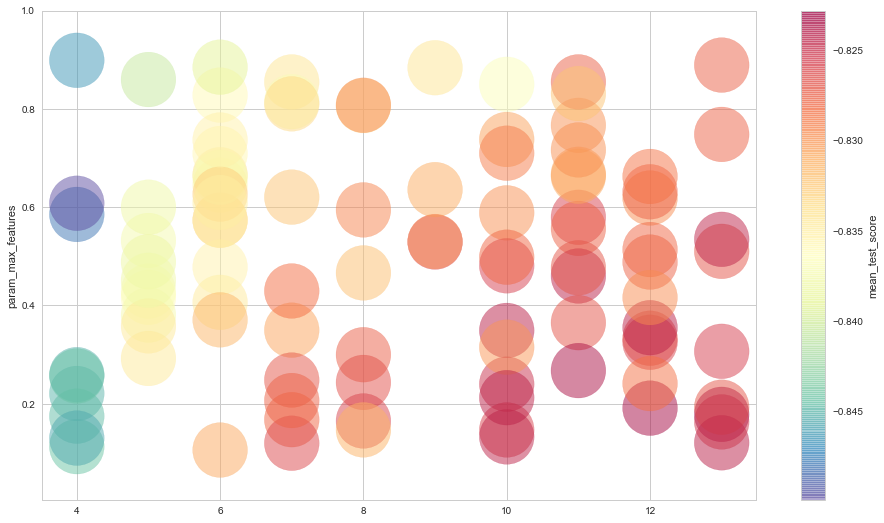

In [65]:
ax = cv_results_df.plot.scatter(x='param_max_depth',
                                y='param_max_features',
                                c='mean_test_score', 
                                s=3000,
                                alpha=0.5,
                                cmap='Spectral_r',
                                figsize=(16,9))

plt.setp(ax.get_xticklabels(), visible=True)
# plt.savefig('tuning.png')
plt.show()

In [60]:
rs_result.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.005, loss='ls', max_depth=13,
             max_features=0.17813769120510711, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=20, min_samples_split=29,
             min_weight_fraction_leaf=0.0, n_estimators=10000,
             presort='auto', random_state=None, subsample=0.9, verbose=0,
             warm_start=False)

In [ ]:
best_estimator = rs_result.best_estimator_

In [ ]:
train_idx, test_idx = split_train_test(X_boruta)

X_train = filtered_df[boruta_genes].iloc[train_idx]
y_train = filtered_df['log_AB'].iloc[train_idx]

X_test = filtered_df[boruta_genes].iloc[test_idx]
y_test = filtered_df['log_AB'].iloc[test_idx]

In [ ]:
train_WT_idx, test_WT_idx = split_train_test(X_boruta)

X_train = filtered_df[boruta_genes].iloc[train_idx]
y_train = filtered_df['log_AB'].iloc[train_idx]

X_test = filtered_df[boruta_genes].iloc[test_idx]
y_test = filtered_df['log_AB'].iloc[test_idx]

### **Step 3**: Train a GBM with optimized parameters.

* extract important features from the trained model

In [ ]:
best_estimator.fit(X_train, y_train, monitor=EarlyStopMonitor())

In [51]:
important_genes_df = pd.DataFrame({'gene': boruta_genes, 
                                   'importance': best_estimator.feature_importances_}).sort_values(by='importance', ascending=False)

In [52]:
important_genes_df.head()

,gene,importance
132,Cst7,0.028797
136,Ctsd,0.023511
131,Cst3,0.019109
657,Tyrobp,0.017876
203,Gfap,0.017761


In [53]:
important_genes_df.to_csv(results_wd + 'important_genes_{}_{}.tsv'.format(genotype, region), sep='\t', index=None)

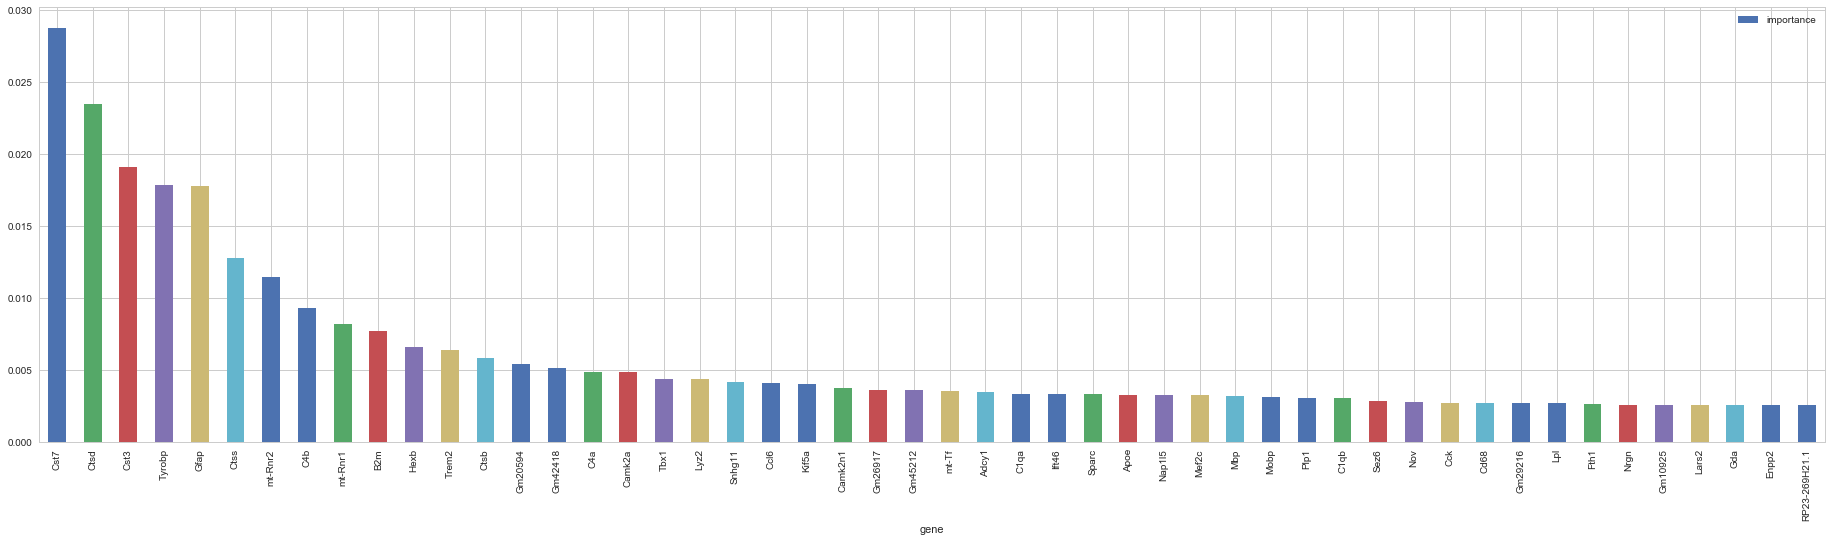

In [54]:
top = 50

important_genes_df[:top].plot.bar(x='gene', y='importance', figsize=(32, 8))
plt.show()

* plotting the predictions vs the actual test values
* pretty OK, but some batch effect?

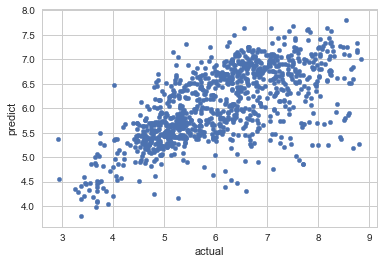

In [55]:
pd.DataFrame({'predict': best_estimator.predict(X_test), 
              'actual': y_test}).plot.scatter(x='actual', y='predict')

plt.show()

* test the performance on some WT examples
* this is **BAD!!!**
* the model is clearly not trained on WT examples and thus cannot well predict the log_AB scores for these

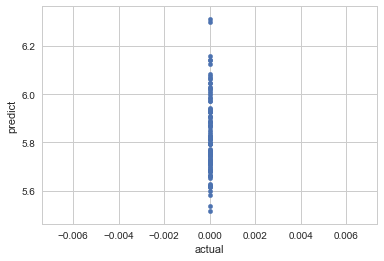

In [56]:
pd.DataFrame({'predict': best_estimator.predict(X_WT_boruta[boruta_genes][:100]), 
              'actual': y_WT_boruta[:100]}).plot.scatter(x='actual', y='predict')

plt.show()

* partial dependence plots

In [57]:
top_genes = important_genes_df['gene'][:50]

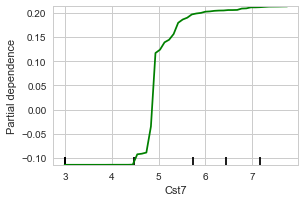

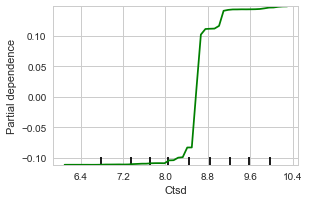

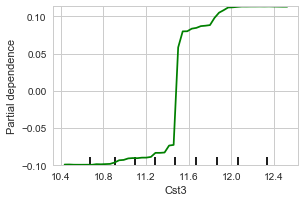

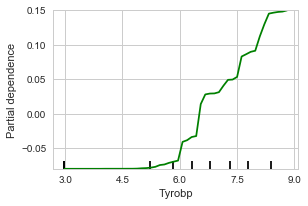

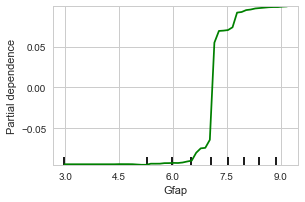

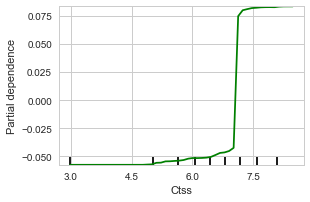

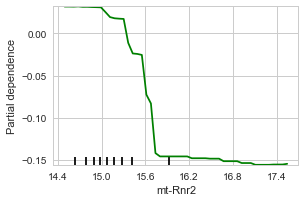

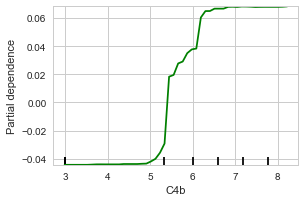

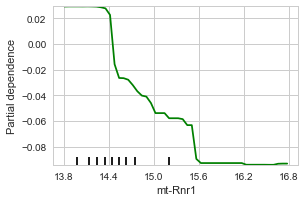

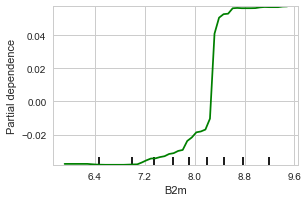

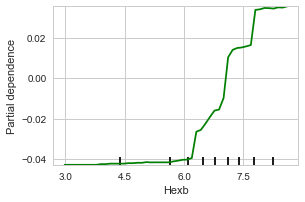

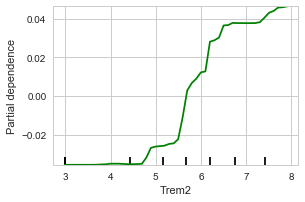

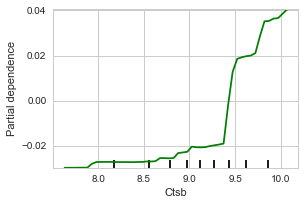

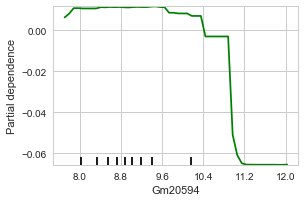

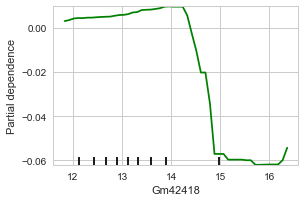

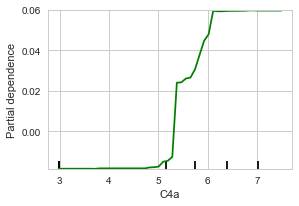

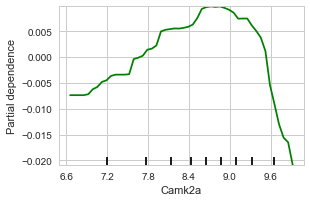

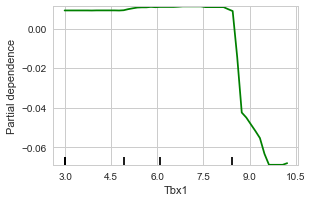

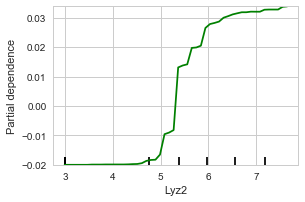

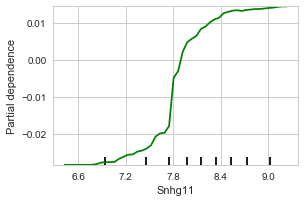

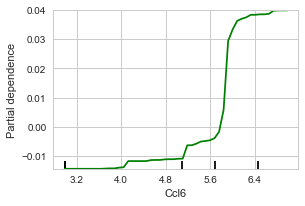

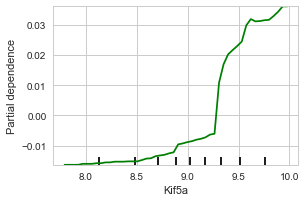

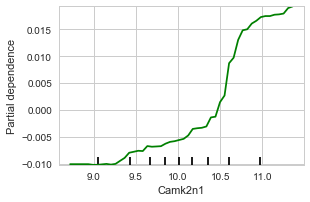

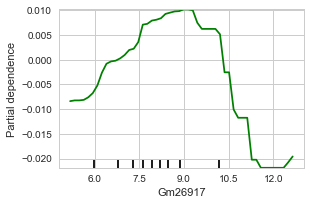

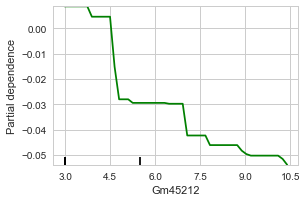

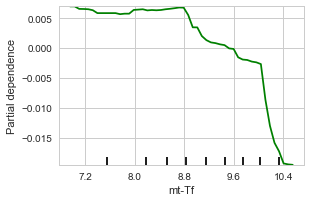

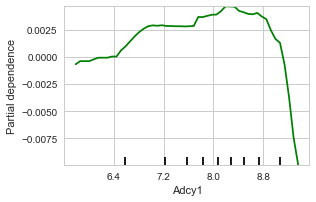

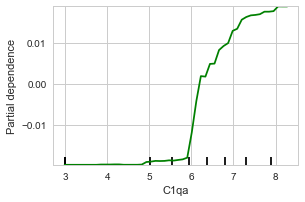

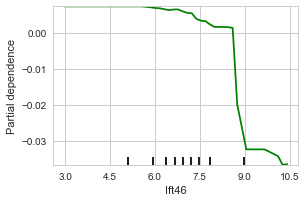

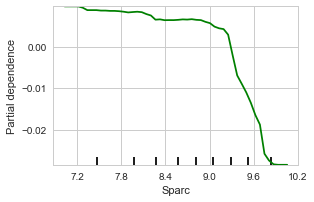

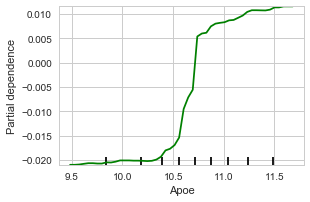

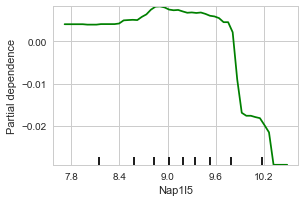

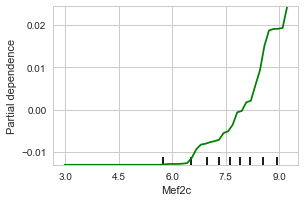

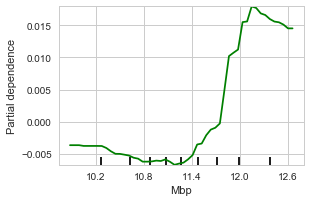

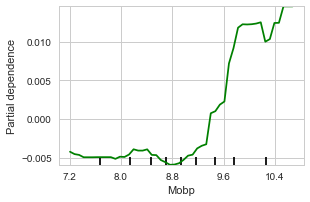

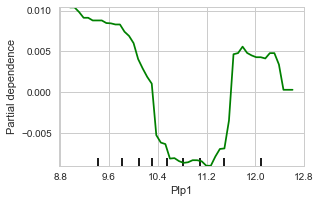

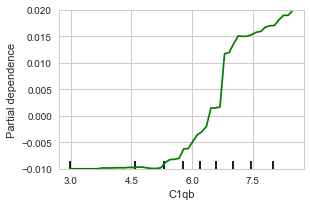

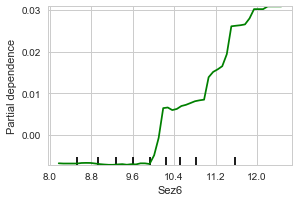

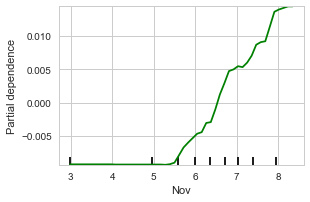

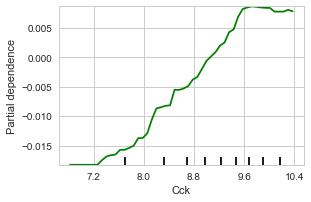

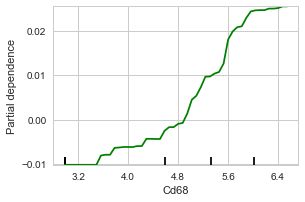

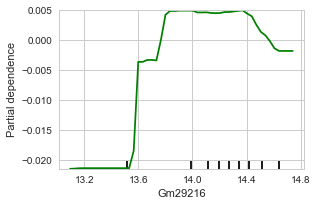

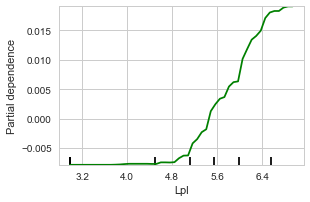

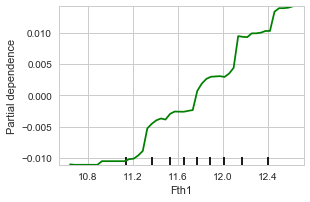

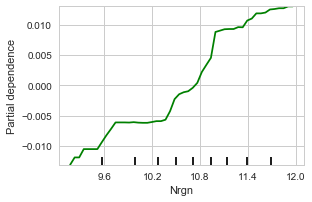

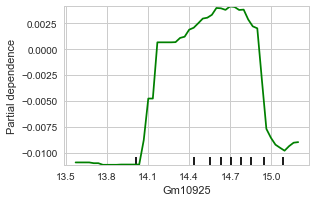

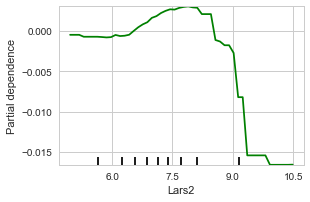

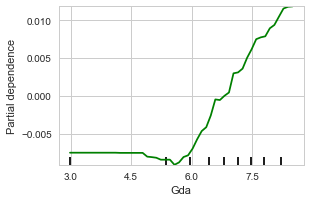

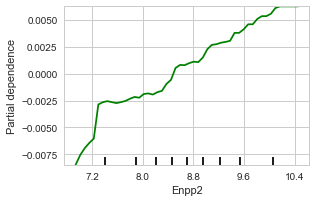

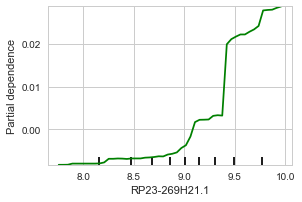

In [58]:
for idx, gene in enumerate(top_genes):
    plot_partial_dependence(best_estimator,
                            X=X_train,
                            features=[boruta_genes.index(gene)],
                            feature_names=boruta_genes,
                            grid_resolution=50,
                            figsize=(4, 4))
    
    plt.show()

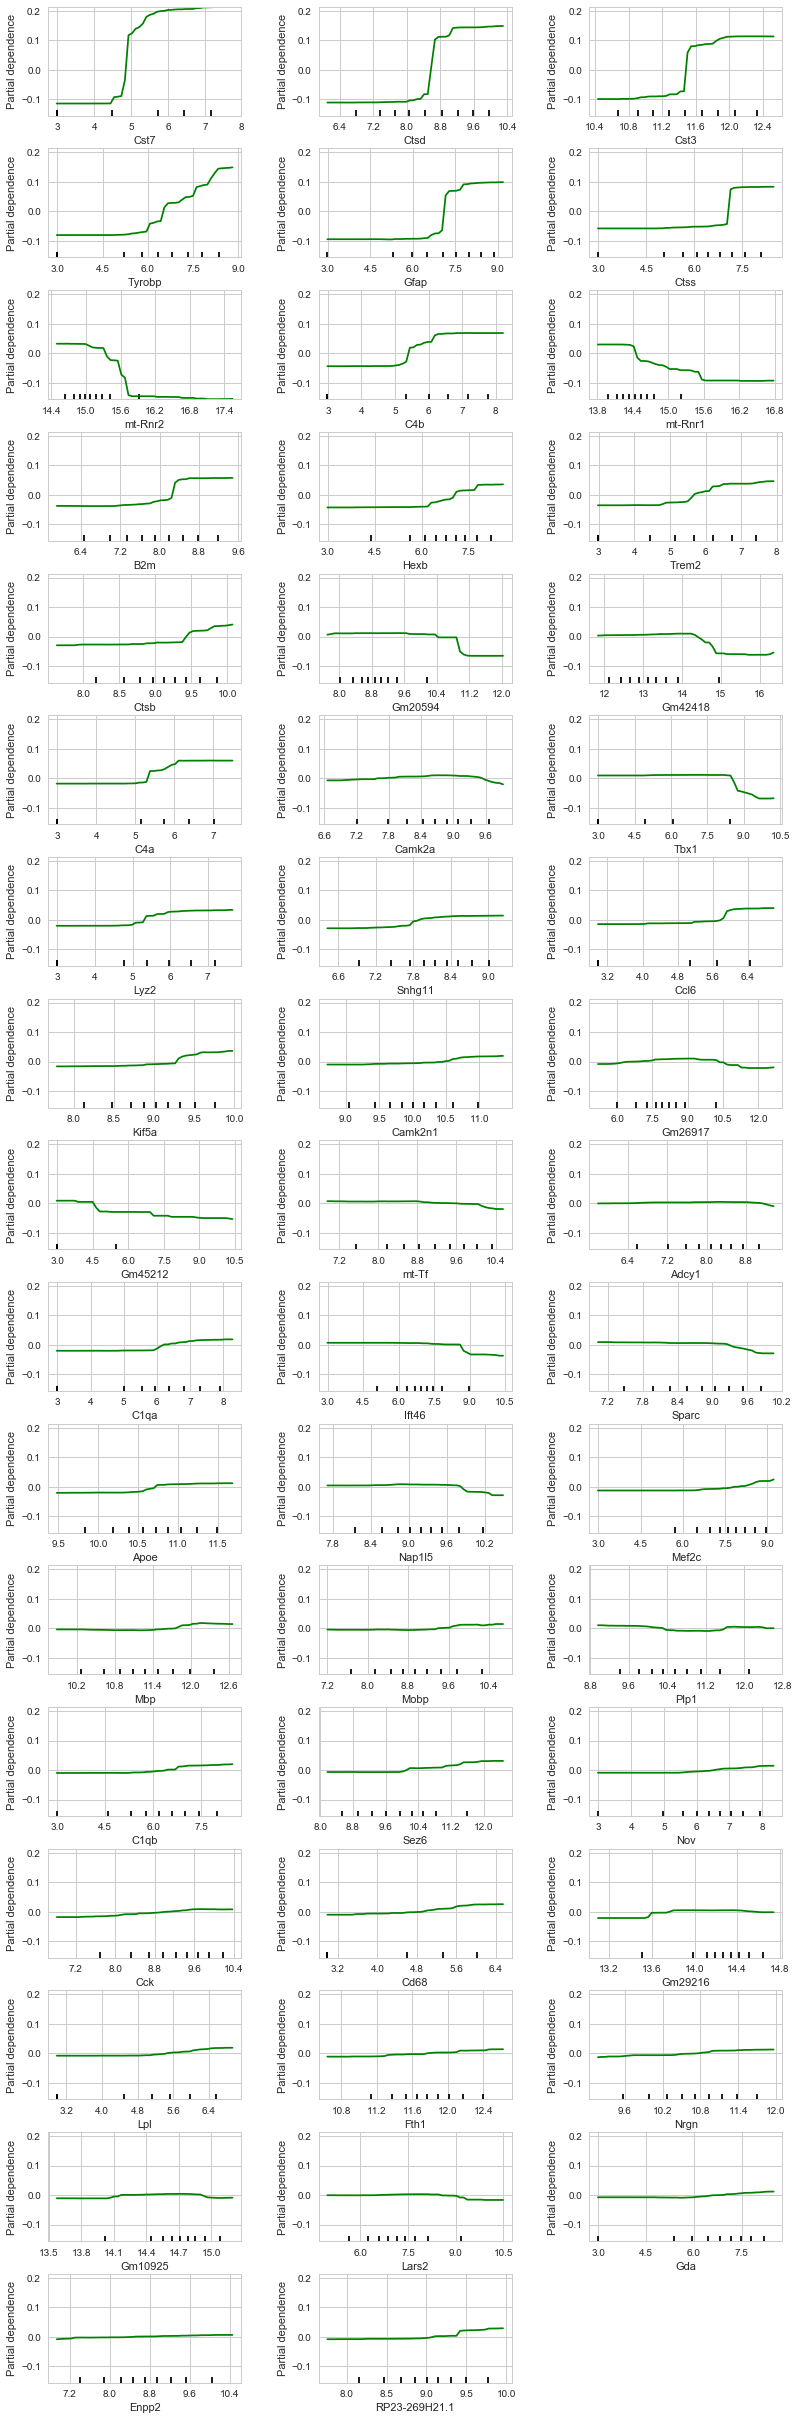

In [63]:
gene_indices = [boruta_genes.index(gene) for gene in top_genes]

plot_partial_dependence(best_estimator,
                        X=X_train,
                        features=gene_indices,
                        feature_names=boruta_genes,
                        grid_resolution=50,
                        n_jobs=1, figsize=(12, 60))
    
plt.show()